In [10]:
import os
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gc

%matplotlib inline

SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 13

plt.rcParams['axes.facecolor']='white'
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [11]:
# Prepare lists to store the flattened images and labels
images = []
labels = []

# Loop over each file in the directory
for filename in os.listdir("Images"):
    file_path = os.path.join("Images", filename)
    with Image.open(file_path) as img:
        images.append(np.array(img))
        # Extract the class label from the filename
        # Example filename: yaleB01_P00A+000E+00.png
        # Extract '01' from 'yaleB01', which is the subject ID
        label = filename.split('_')[0]
        label = label[5:7]
        labels.append(label)

# Convert lists to numpy arrays
image_matrix = np.array(images)
label_array = np.array(labels)

#Apply data normalization with mean and standard deviation
image_matrix = (image_matrix - np.mean(image_matrix, axis=0)) / np.std(image_matrix, axis=0)

print("Image matrix shape:", image_matrix.shape)
print("Labels array shape:", label_array.shape)

Image matrix shape: (2414, 192, 168)
Labels array shape: (2414,)


In [12]:
# Unique classes in the dataset
unique_classes = np.unique(labels)

# Initialize lists to hold the split results
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

train_indices = []
test_indices = []

for cls in unique_classes:
    indices = np.where(label_array == cls)[0]
    train_idx, test_idx = train_test_split(indices, train_size=0.75, random_state=42, shuffle=True)
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

# Use the indices to split both the original and transformed datasets
X_train = image_matrix[train_indices]
X_test = image_matrix[test_indices]
y_train = label_array[train_indices].astype(int)
y_test = label_array[test_indices].astype(int)

#Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train, X_train)  # Autoencoder uses the same data for input and target
test_dataset = TensorDataset(X_test, X_test)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Parameters
input_dim = len(X_train[0])
encoding_dim = 32  # Arbitrary n, you can change it based on your needs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

#Clear memory
torch.cuda.empty_cache()
gc.collect()

Device:  cuda


200075

In [15]:
class ConvAutoencoder(nn.Module):
    def __init__(self, n, input_dim):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, 2, stride=2),  # Input: (1, 192, 168), Output: (4, 96, 84)
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 16, 2, stride=2),  # Output: (16, 48, 42)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, 2, stride=2),  # Output: (64, 24, 21)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * int(input_dim[0] / 8)  * int(input_dim[1] / 8), n)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(n, 64 * int(input_dim[0] / 8) * int(input_dim[1] / 8)),
            nn.Unflatten(dim=1, unflattened_size=(64, int(input_dim[0] / 8), int(input_dim[1] / 8))),
            nn.ConvTranspose2d(64, 16, 2, stride=2),  # Output: (16, 48, 42)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, 2, stride=2),  # Output: (4, 96, 84)
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, 2, stride=2),   # Output: (1, 192, 168)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

n = 20  # example latent dimension
model = ConvAutoencoder(n, (image_matrix.shape[1], image_matrix.shape[2])).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

# Training the autoencoder
num_epochs = 100

In [16]:
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, targets = data
        inputs, targets = inputs.unsqueeze(1).to(device), targets.unsqueeze(1).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.6038
Epoch [2/100], Loss: 0.9856
Epoch [3/100], Loss: 1.1102
Epoch [4/100], Loss: 0.4593
Epoch [5/100], Loss: 0.3069
Epoch [6/100], Loss: 0.2667
Epoch [7/100], Loss: 0.9534
Epoch [8/100], Loss: 0.6778
Epoch [9/100], Loss: 0.2265
Epoch [10/100], Loss: 0.2275
Epoch [11/100], Loss: 2.1360
Epoch [12/100], Loss: 0.4422
Epoch [13/100], Loss: 0.9677
Epoch [14/100], Loss: 0.1984
Epoch [15/100], Loss: 0.1726
Epoch [16/100], Loss: 1.8064
Epoch [17/100], Loss: 0.1984
Epoch [18/100], Loss: 1.5836
Epoch [19/100], Loss: 0.8353
Epoch [20/100], Loss: 0.2096
Epoch [21/100], Loss: 0.3030
Epoch [22/100], Loss: 0.1378
Epoch [23/100], Loss: 0.1717
Epoch [24/100], Loss: 0.1593
Epoch [25/100], Loss: 0.4852
Epoch [26/100], Loss: 0.1333
Epoch [27/100], Loss: 0.1238
Epoch [28/100], Loss: 0.4099
Epoch [29/100], Loss: 0.2581
Epoch [30/100], Loss: 0.1508
Epoch [31/100], Loss: 0.1737
Epoch [32/100], Loss: 0.1677
Epoch [33/100], Loss: 0.4257
Epoch [34/100], Loss: 0.2690
Epoch [35/100], Loss: 0

In [17]:
# Extract reduced dimensions using the encoder part
with torch.no_grad():
    X_train_encoded = model.encoder(X_train.unsqueeze(1).to(device)).cpu().numpy()
    X_test_encoded = model.encoder(X_test.unsqueeze(1).to(device)).cpu().numpy()

# Train a linear classifier on the reduced-dimensional data
logistic_classifier = LogisticRegression(random_state = 42, C = 0.005, max_iter = 250)
svm_classifier = SVC(kernel = 'linear', random_state = 42, C = 0.001, max_iter = 250)

In [18]:
def evaluate_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot = True, fmt='d', cmap = 'Blues', xticklabels = unique_classes, yticklabels = unique_classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return classifier

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.69      0.81        16
           2       1.00      0.94      0.97        16
           3       0.79      0.94      0.86        16
           4       0.94      0.94      0.94        16
           5       1.00      0.94      0.97        16
           6       0.74      0.88      0.80        16
           7       1.00      0.94      0.97        16
           8       0.93      0.88      0.90        16
           9       0.94      1.00      0.97        16
          10       1.00      0.88      0.93        16
          11       0.93      0.93      0.93        15
          12       1.00      0.73      0.85        15
          13       0.93      0.93      0.93        15
          15       1.00      0.81      0.90        16
          16       0.86      0.75      0.80        16
          17       0.88      0.94      0.91        16
          18       1.00      0.75      0.86

C:\Users\korki\anaconda3\envs\mnlp\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


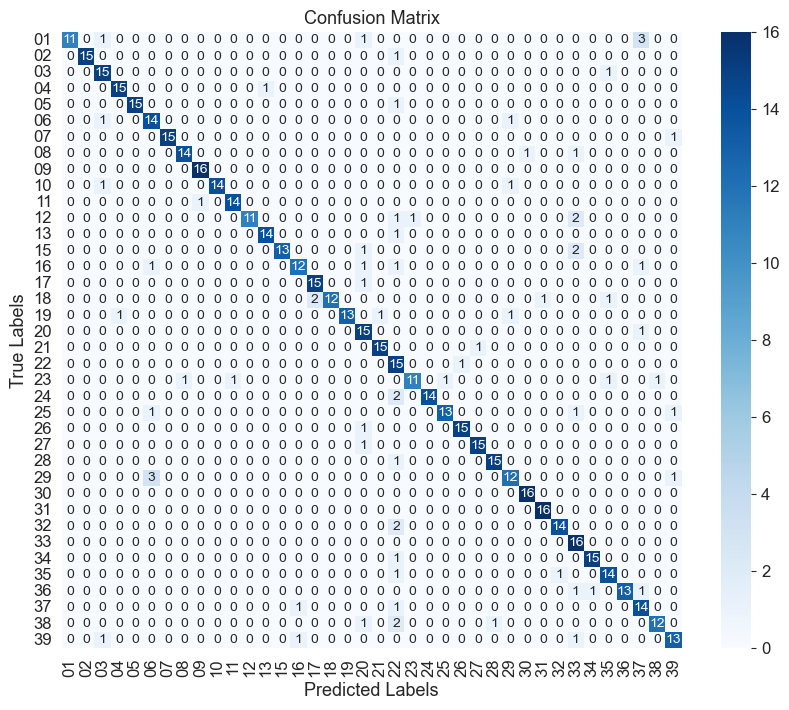

LogisticRegression(C=0.005, max_iter=250, random_state=42)

In [19]:
evaluate_model(logistic_classifier, X_train_encoded, y_train.numpy(), X_test_encoded, y_test.numpy())

C:\Users\korki\anaconda3\envs\mnlp\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           1       0.89      1.00      0.94        16
           2       1.00      0.94      0.97        16
           3       0.83      0.94      0.88        16
           4       1.00      0.94      0.97        16
           5       1.00      0.94      0.97        16
           6       1.00      0.88      0.93        16
           7       1.00      0.94      0.97        16
           8       1.00      0.94      0.97        16
           9       1.00      1.00      1.00        16
          10       1.00      0.94      0.97        16
          11       1.00      1.00      1.00        15
          12       1.00      0.87      0.93        15
          13       0.93      0.93      0.93        15
          15       1.00      0.81      0.90        16
          16       1.00      0.94      0.97        16
          17       0.93      0.88      0.90        16
          18       1.00      0.88      0.93

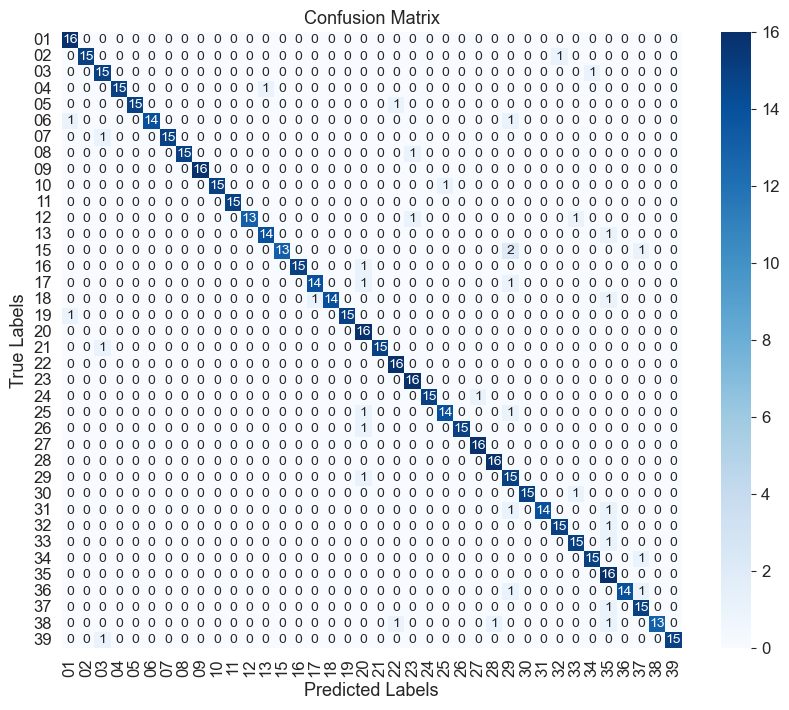

SVC(C=0.001, kernel='linear', max_iter=250, random_state=42)

In [20]:
evaluate_model(svm_classifier, X_train_encoded, y_train, X_test_encoded, y_test)